In [1]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

### Loading the data and exploring the variables.

In [2]:
data = pd.read_csv('/Users/cillian/Desktop/Ironhack/Ironhack-unit-4/lab-imbalanced-data/files_for_lab/customer_churn.csv')
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
data['Churn'].value_counts()
# checking the value counts for the target feature shows we have a class imbalance.

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [5]:
data = data.set_index('customerID')
data.columns = data.columns.str.lower()

In [6]:
df = data[['seniorcitizen', 'tenure','monthlycharges','churn']]
df

,seniorcitizen,tenure,monthlycharges,churn
customerID,,,,
7590-VHVEG,0,1,29.85,No
5575-GNVDE,0,34,56.95,No
3668-QPYBK,0,2,53.85,Yes
7795-CFOCW,0,45,42.30,No
9237-HQITU,0,2,70.70,Yes
...,...,...,...,...
6840-RESVB,0,24,84.80,No
2234-XADUH,0,72,103.20,No
4801-JZAZL,0,11,29.60,No


In [7]:
df.describe()

,seniorcitizen,tenure,monthlycharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
df.dtypes

seniorcitizen       int64
tenure              int64
monthlycharges    float64
churn              object
dtype: object

In [9]:
df['seniorcitizen']= df['seniorcitizen'].astype('object')
# I changed the seniorcitizen column to a str as I believe it represents True or False rather than the number of
# people. I looked at the value counts of the column to come to this conclusion.
df

/var/folders/hm/lc2tr7v957lgz2xk_p_fhct40000gn/T/ipykernel_13877/3000519865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seniorcitizen']= df['seniorcitizen'].astype('object')


,seniorcitizen,tenure,monthlycharges,churn
customerID,,,,
7590-VHVEG,0,1,29.85,No
5575-GNVDE,0,34,56.95,No
3668-QPYBK,0,2,53.85,Yes
7795-CFOCW,0,45,42.30,No
9237-HQITU,0,2,70.70,Yes
...,...,...,...,...
6840-RESVB,0,24,84.80,No
2234-XADUH,0,72,103.20,No
4801-JZAZL,0,11,29.60,No


## Getting the model benchmark

In [10]:
X = pd.get_dummies(df.drop('churn', axis =1)) 
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))
print(classification.score(X_test,y_test))

              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1035
         Yes       0.63      0.45      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409

0.7835344215755855


<Axes: >

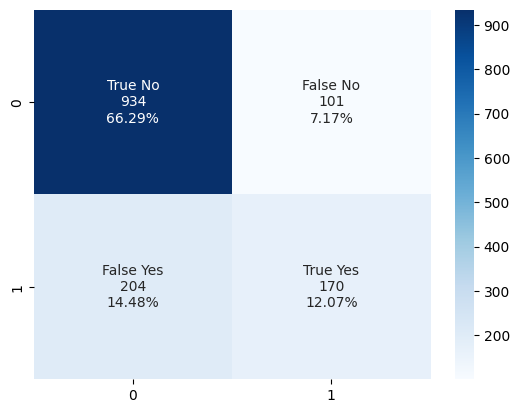

In [11]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

As we can see due to the data imbalance with No's, they are more accurately predicted than Yes's which we will try to balance with Feature Engineering. The current model works well because there are a lot of rows but not many columns.

### Feature Scaling using Standard scaler

In [12]:
scaler = StandardScaler()

X = pd.get_dummies(df.drop('churn', axis =1)) 
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train_scaled, y_train)

predictions = classification.predict(X_test_scaled)
print(classification_report (y_test, predictions))
print(classification.score(X_test,y_test))



              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1035
         Yes       0.63      0.45      0.53       374

    accuracy                           0.78      1409
   macro avg       0.73      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409

0.5443577004968062


/Users/cillian/anaconda3/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


<Axes: >

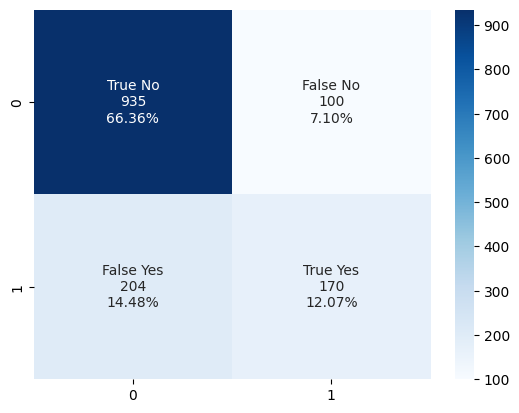

In [13]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Using SMOTE

In [14]:
X = pd.get_dummies(df.drop('churn', axis=1))
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

churn
No     4139
Yes    4139
Name: count, dtype: int64

In [15]:
# Seeing if we did not add fake data to our set
y_test.value_counts()

churn
No     1035
Yes     374
Name: count, dtype: int64

In [16]:
classification = LogisticRegression(random_state=42, max_iter=100000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))
print(classification.score(X_test,y_test))

              precision    recall  f1-score   support

          No       0.88      0.75      0.81      1035
         Yes       0.50      0.71      0.59       374

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409

0.7381121362668559


<Axes: >

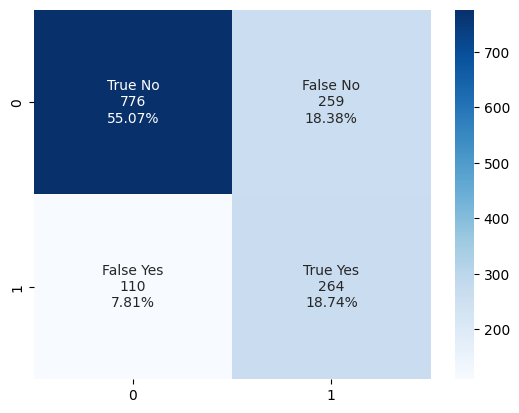

In [17]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Compared to our benchmark the model doesn't improve with the precision but with recall it is much more balanced and slightly better with the f1-score.

In [18]:
# Now lets try TomekLinks
X = df.drop('churn', axis=1)
y = df['churn']

tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()

churn
No     4712
Yes    1869
Name: count, dtype: int64

In [19]:
X = data[['tenure', 'seniorcitizen', 'monthlycharges']]
y = data['churn']

tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Xtl_train, ytl_train = tomek.fit_resample(X, y)

classification = LogisticRegression(random_state=42, max_iter=100000)
classification.fit(Xtl_train, ytl_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))
print(classification.score(X_test,y_test))

              precision    recall  f1-score   support

          No       0.84      0.87      0.85      1035
         Yes       0.60      0.54      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409

0.7806955287437899


<Axes: >

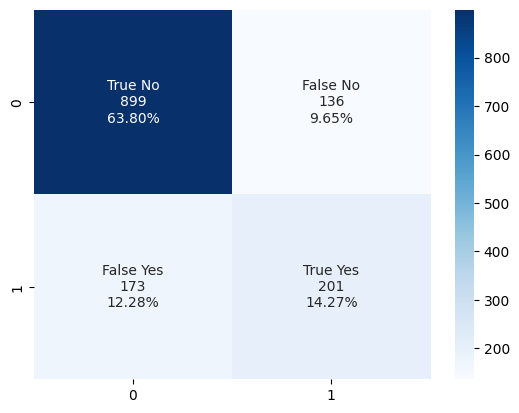

In [20]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes',]

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Results and insights
   - Smote seems to be the best fit for predicting customer churn as it predicts the most true yes's  with tomek links behind albeit with a worse recall score and slightly worse f1_score.
   - Even though are simple model gave us a good score it was important to look at our precision, recall and f1-score to properly evaulate the model.